In [1]:
# Download all the necessay libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Title of Project: Optimizing Dry Bean Sorting Efficiency with Automated Image Classification Techniques

In [2]:

# Read dataset

url <- "https://github.com/NaziaNadir/dsci-100-2023-007-group-8/raw/main/Dry_Bean_Dataset.csv"
BeanData <- read_csv(url)

# remove missing values if any
BeanData <- filter(BeanData, rowSums(is.na(BeanData)) != ncol(BeanData))




Rows: 13611 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (16): Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Spliting the data into training and testing set

In [3]:

#Set the seed. Don't remove this!
set.seed(3456) 

# Randomly take 75% of the data in the training set. 
# This will be proportional to the different number of bean Classes in the dataset.

bean_split <- initial_split(BeanData, prop = 0.2, strata = Class)  
bean_train <- training(bean_split)   
bean_test <- testing(bean_split) # wont touch it until the best classifier is obtained

# your code here
bean_train
bean_test




Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
47981,809.088,291.6540,210.0432,1.388543,0.6937880,48451,247.1666,0.7697775,0.9902995,0.9210594,0.8474651,0.006078530,0.001934041,0.7181971,0.9972476,BARBUNYA
49777,861.277,300.7570,211.6169,1.421234,0.7105824,50590,251.7500,0.8019107,0.9839296,0.8432433,0.8370543,0.006042088,0.001829706,0.7006599,0.9958015,BARBUNYA
55660,936.905,325.9134,217.9664,1.495246,0.7434546,56773,266.2114,0.7054499,0.9803956,0.7968232,0.8168165,0.005855432,0.001607817,0.6671892,0.9976118,BARBUNYA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57239,919.405,356.0448,206.1806,1.726859,0.8152665,58301,269.9610,0.6965924,0.9817842,0.8509189,0.7582220,0.006220319,0.001268172,0.5749007,0.9927726,SIRA
57790,920.668,360.9603,204.7025,1.763341,0.8236453,58342,271.2573,0.7359815,0.9905385,0.8567546,0.7514878,0.006246069,0.001228780,0.5647338,0.9958183,SIRA
57944,921.449,353.8206,210.4090,1.681585,0.8039647,59041,271.6185,0.6863532,0.9814197,0.8575821,0.7676727,0.006106252,0.001308154,0.5893215,0.9909941,SIRA


Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
29380,624.110,212.8261,175.9311,1.209713,0.5627273,29690,193.4109,0.7781132,0.9895588,0.9478495,0.9087742,0.007243912,0.003047733,0.8258706,0.9990661,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
42101,757.499,281.5764,190.7131,1.476439,0.7357022,42494,231.5268,0.7999430,0.9907516,0.9220153,0.8222522,0.006688116,0.001885835,0.6760986,0.9982187,DERMASON
42147,763.779,283.3826,190.2757,1.489326,0.7410548,42667,231.6532,0.7053891,0.9878126,0.9079065,0.8174575,0.006723673,0.001852025,0.6682367,0.9952224,DERMASON
42159,772.237,295.1427,182.2047,1.619841,0.7866930,42600,231.6862,0.7889625,0.9896479,0.8883804,0.7849972,0.007000705,0.001639812,0.6162206,0.9981796,DERMASON


# Variable Selection

Use of histograms to look at the distribtion of each variable
The variables with high overlapping are removed while the varibales with distinct classes are taken

Warning message:
“Ignoring unknown parameters: bindwidth”


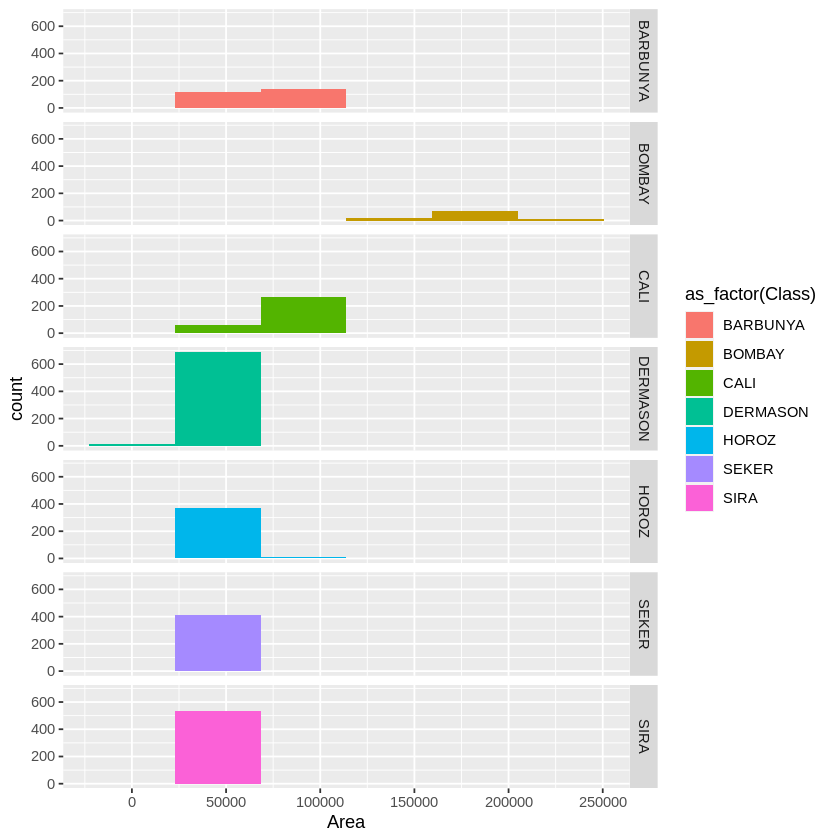

In [4]:
bean_area <- bean_train|>
 ggplot( aes(x = Area, fill = as_factor(Class))) +
  geom_histogram( bins = 6, bindwidth = 0.1) +
  facet_grid(rows = vars(Class)) 

bean_area


### The distribution is sistinct and therefore taken

In [5]:
bean_Perimeter <- bean_train|>
 ggplot( aes(x = Perimeter, fill = as_factor(Class))) +
  geom_histogram (bins = 6) +
  facet_grid(rows = vars(Class)) 

bean_MajorAxisLength<- bean_train|>
 ggplot( aes(x = MajorAxisLength, fill = as_factor(Class))) +
  geom_histogram() +
  facet_grid(rows = vars(Class)) 

bean_MinorrAxisLength <- bean_train|>
 ggplot( aes(x = MinorAxisLength, fill = as_factor(Class))) +
  geom_histogram() +
  facet_grid(rows = vars(Class)) 

bean_AspectRation<- bean_train|>
 ggplot( aes(x = AspectRation, fill = as_factor(Class))) +
  geom_histogram(bins = 6) +
  facet_grid(rows = vars(Class)) 

bean_Eccentricity <- bean_train|>
 ggplot( aes(x = Eccentricity, fill = as_factor(Class))) +
  geom_histogram(binwidth =  0.1, bins = 6) +
  facet_grid(rows = vars(Class)) 


bean_ConvexArea <- bean_train|>
 ggplot( aes(x = ConvexArea, fill = as_factor(Class))) +
  geom_histogram(bins = 6) +
  facet_grid(rows = vars(Class)) 


bean_EquivDiameter <- bean_train|>
 ggplot( aes(x = EquivDiameter, fill = as_factor(Class))) +
  geom_histogram(bins = 6) +
  facet_grid(rows = vars(Class)) 



bean_Extent <- bean_train|>
 ggplot( aes(x = Extent, fill = as_factor(Class))) +
  geom_histogram(binwidth =  0.1, bins = 30) +
  facet_grid(rows = vars(Class)) 


bean_Solidity <- bean_train|>
 ggplot( aes(x = Solidity, fill = as_factor(Class))) +
  geom_histogram(binwidth =  0.1, bins = 30) +
  facet_grid(rows = vars(Class)) 


bean_roundness <- bean_train|>
 ggplot( aes(x = roundness, fill = as_factor(Class))) +
  geom_histogram(binwidth =  0.1, bins = 30) +
  facet_grid(rows = vars(Class)) 


bean_Compactness <- bean_train|>
 ggplot( aes(x = Compactness, fill = as_factor(Class))) +
  geom_histogram(binwidth =  0.1, bins = 60) +
  facet_grid(rows = vars(Class)) 


bean_ShapeFactor1 <- bean_train|>
 ggplot( aes(x = ShapeFactor1, fill = as_factor(Class))) +
  geom_histogram(binwidth =  0.1, bins = 30) +
  facet_grid(rows = vars(Class)) 


bean_ShapeFactor2 <- bean_train|>
 ggplot( aes(x = ShapeFactor2, fill = as_factor(Class))) +
  geom_histogram(binwidth =  0.1, bins = 30) +
  facet_grid(rows = vars(Class)) 


bean_ShapeFactor3<- bean_train|>
 ggplot( aes(x = ShapeFactor3, fill = as_factor(Class))) +
  geom_histogram(binwidth =  0.1, bins = 30) +
  facet_grid(rows = vars(Class)) 


bean_ShapeFactor4<- bean_train|>
 ggplot( aes(x = ShapeFactor4, fill = as_factor(Class))) +
  geom_histogram(binwidth =  0.1, bins = 30) +
  facet_grid(rows = vars(Class))

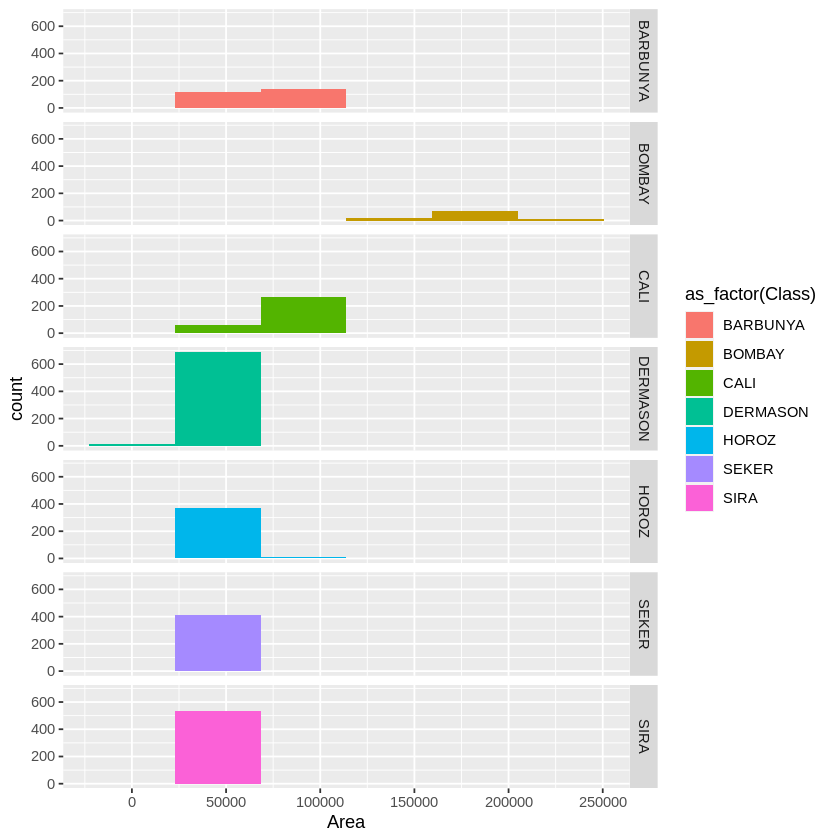

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



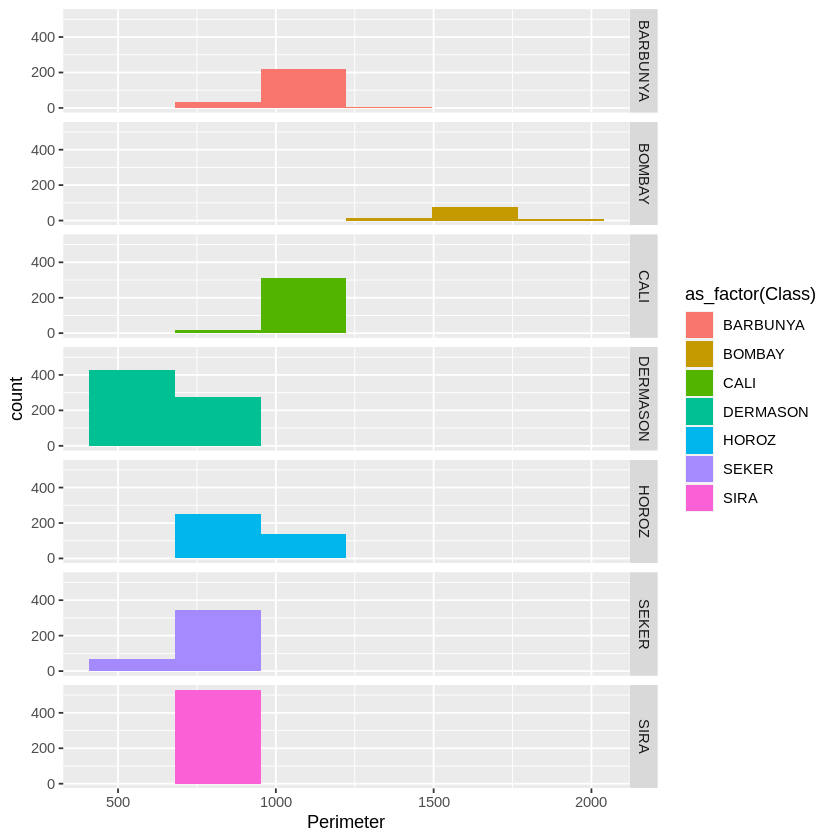

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



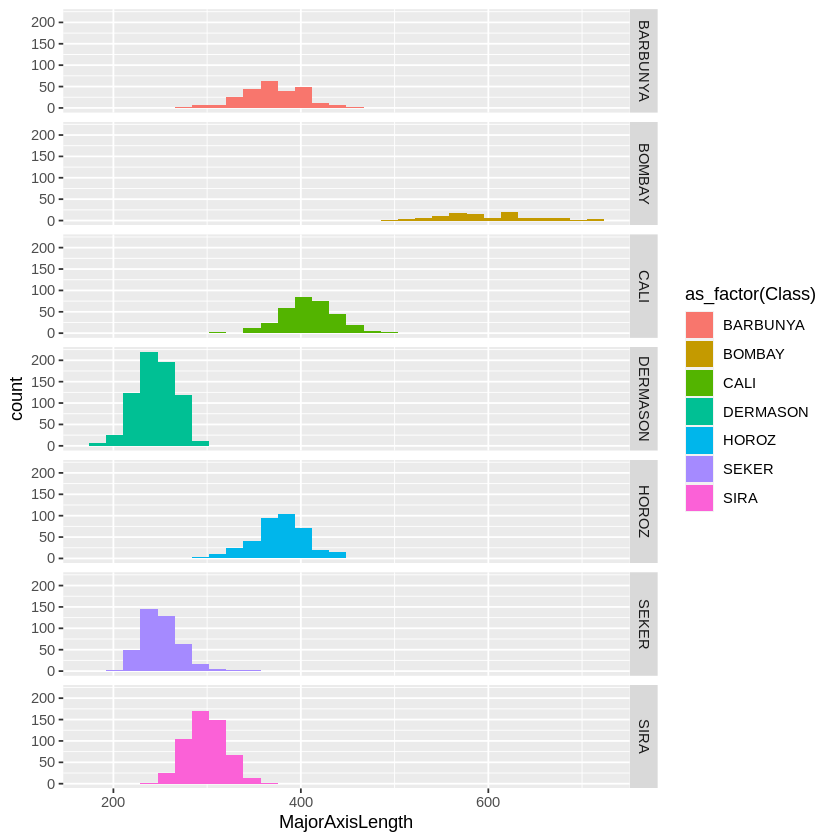

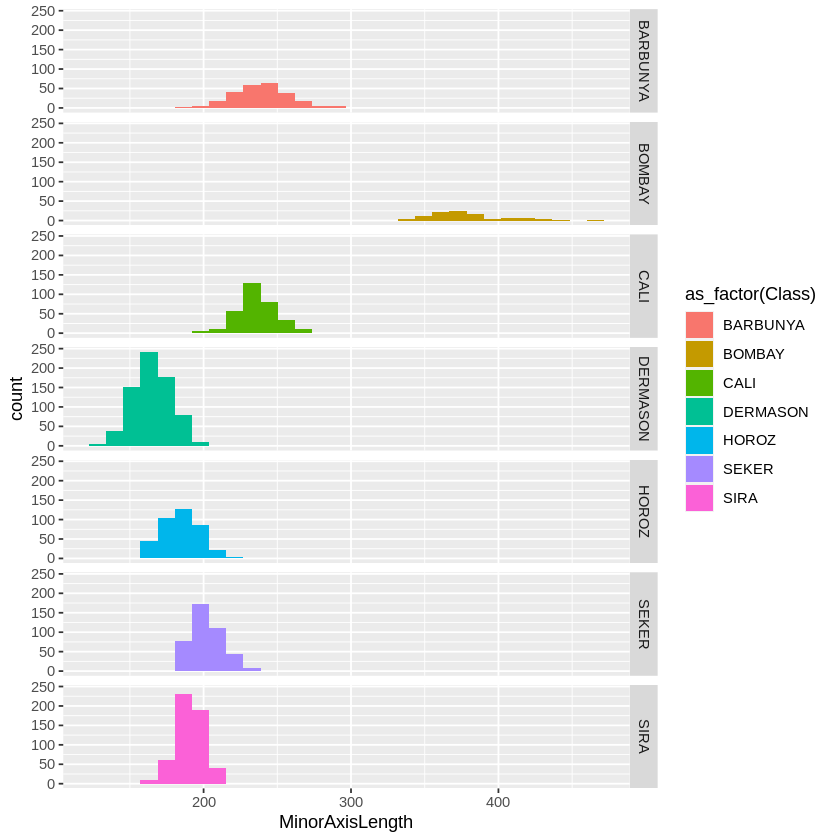

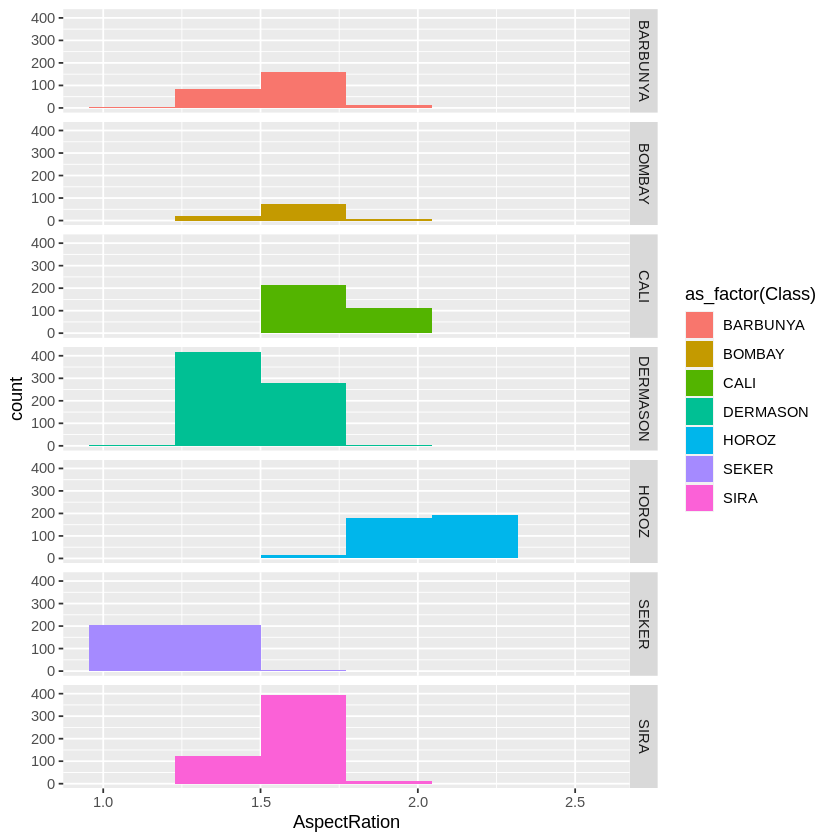

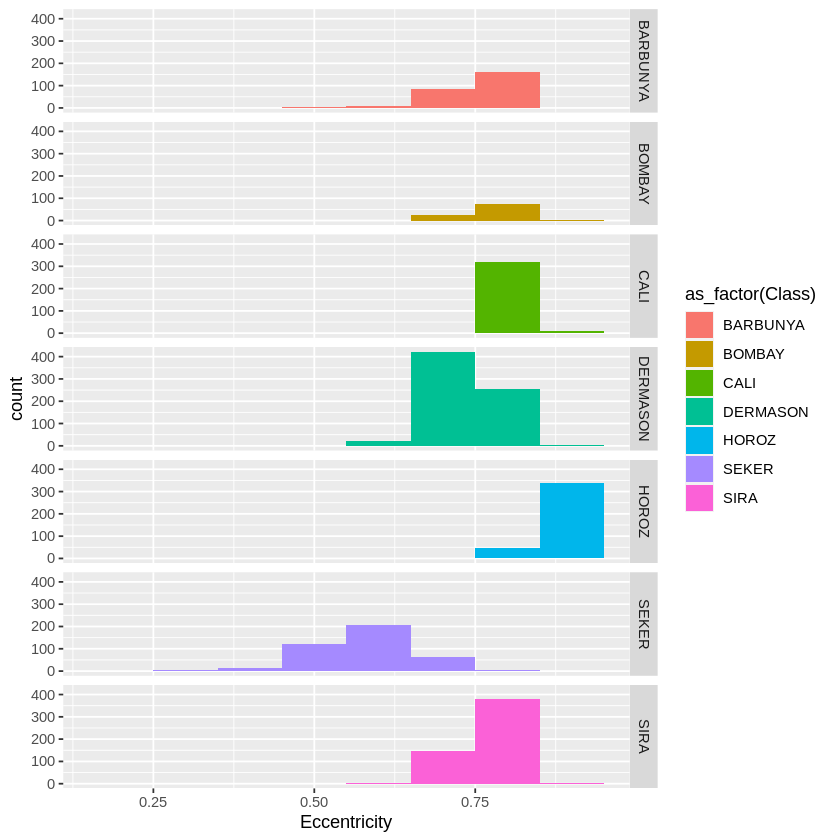

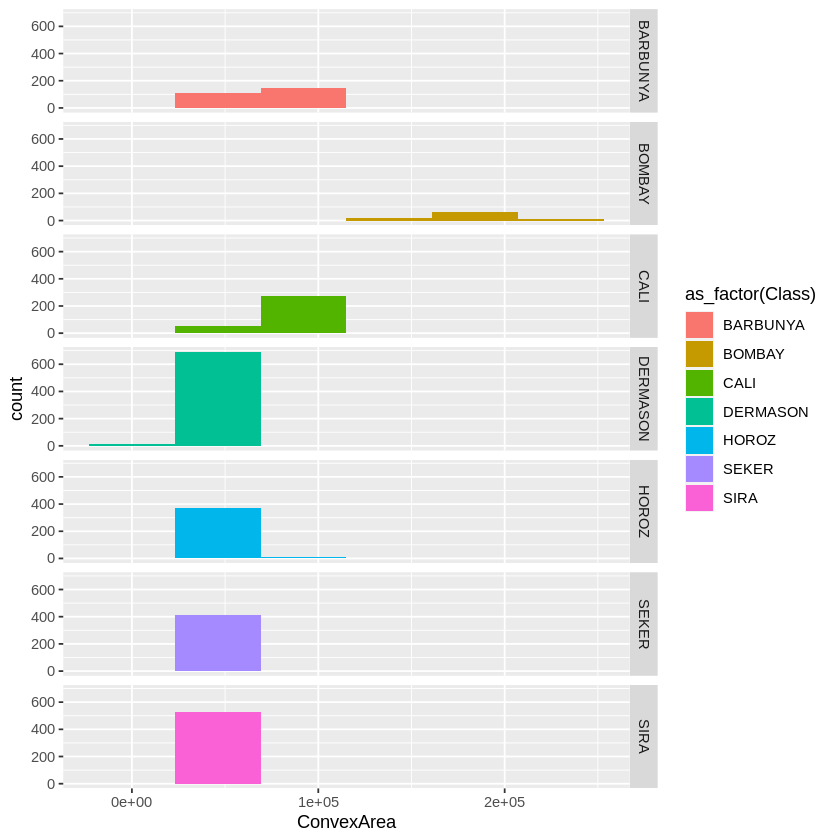

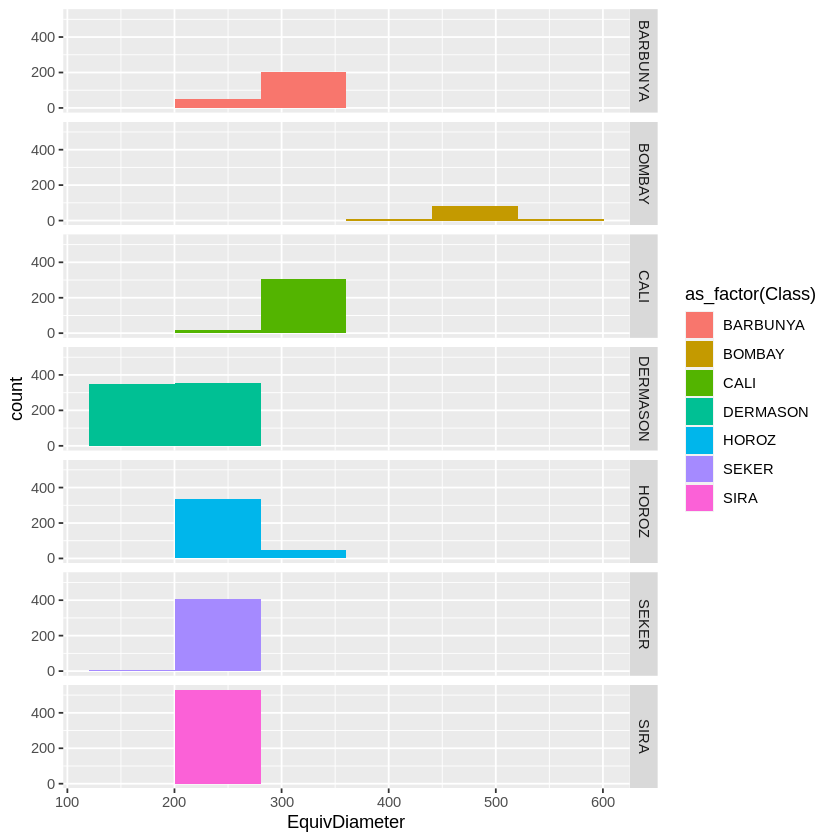

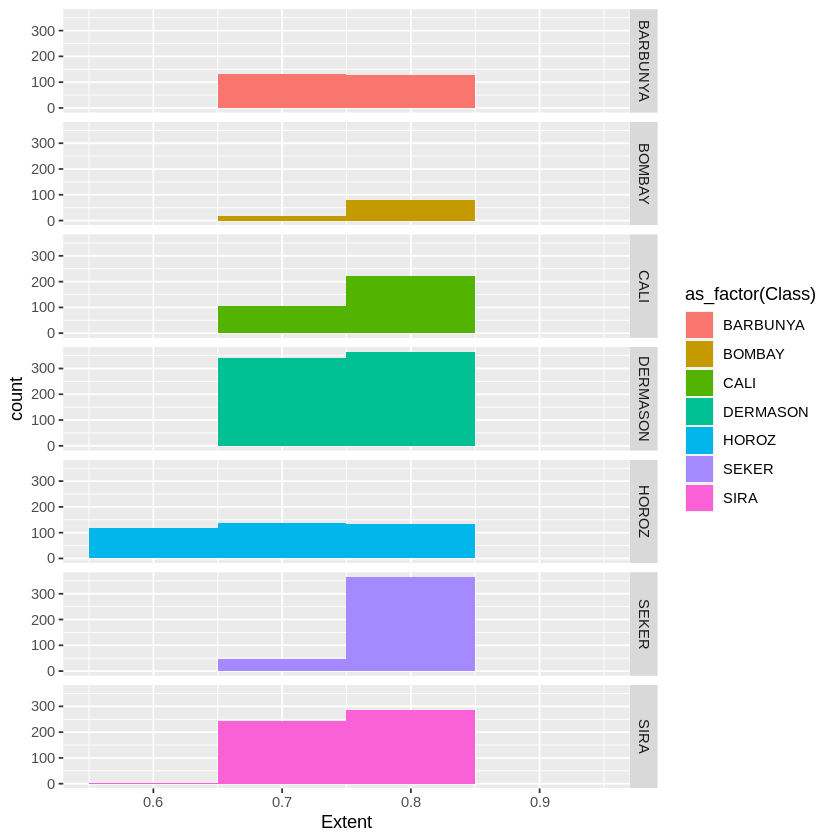

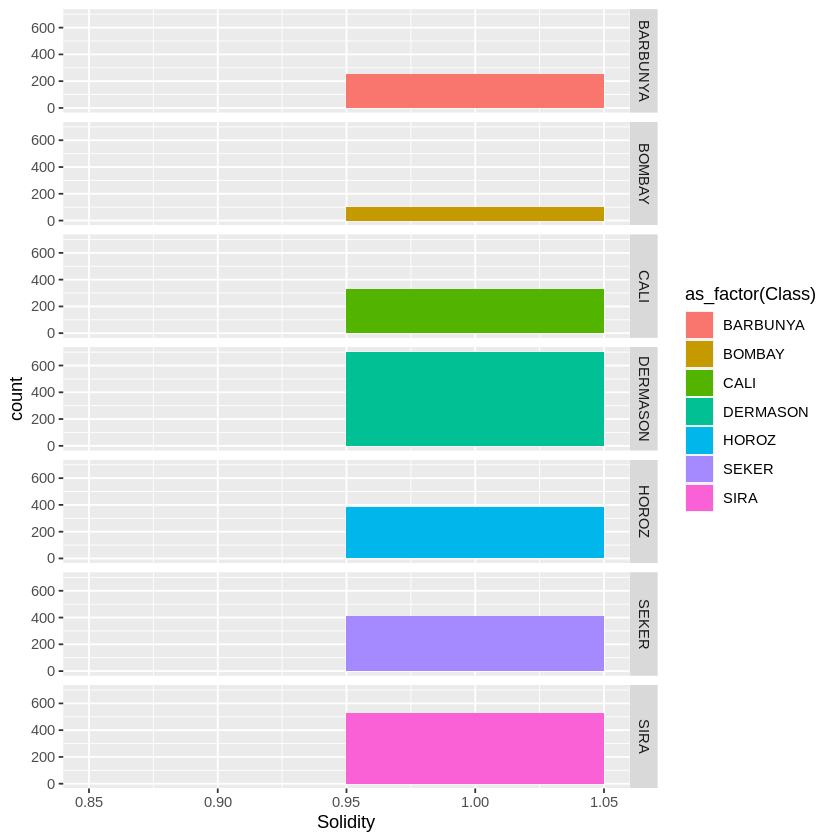

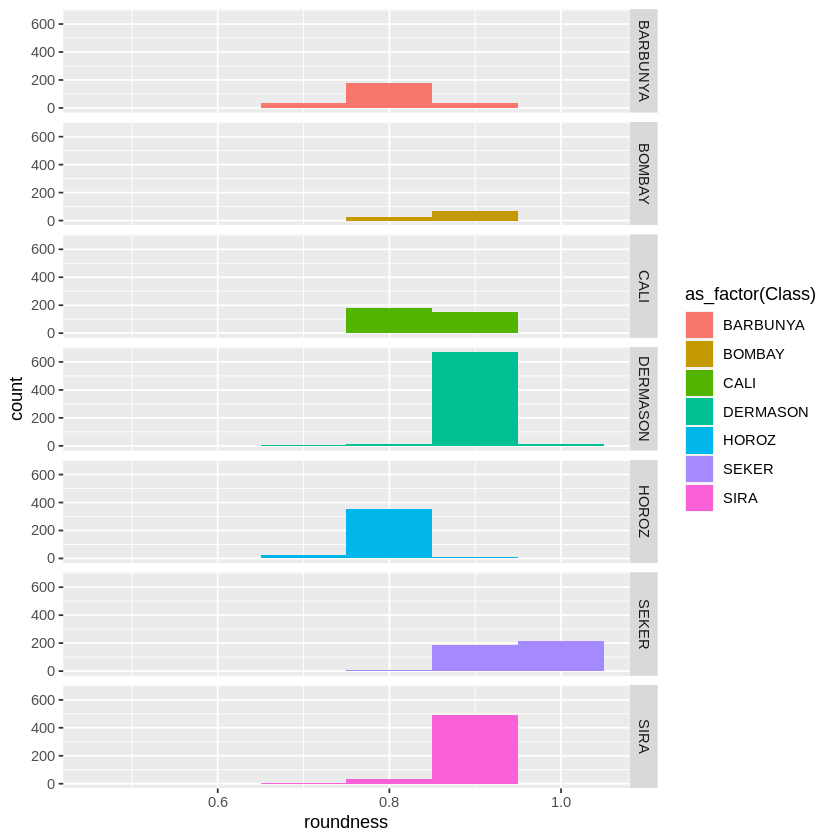

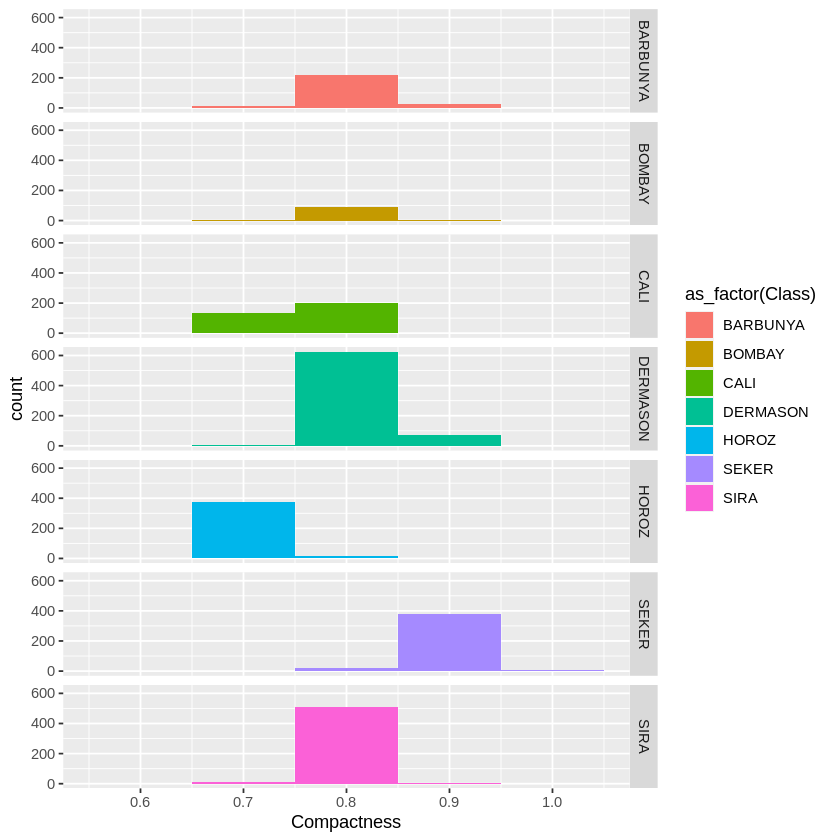

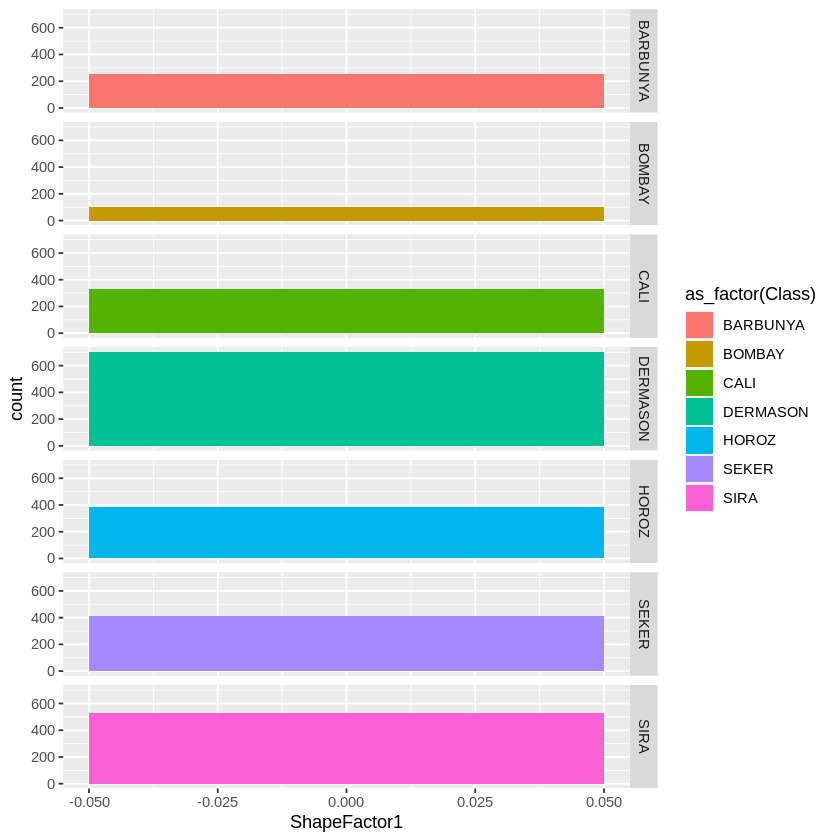

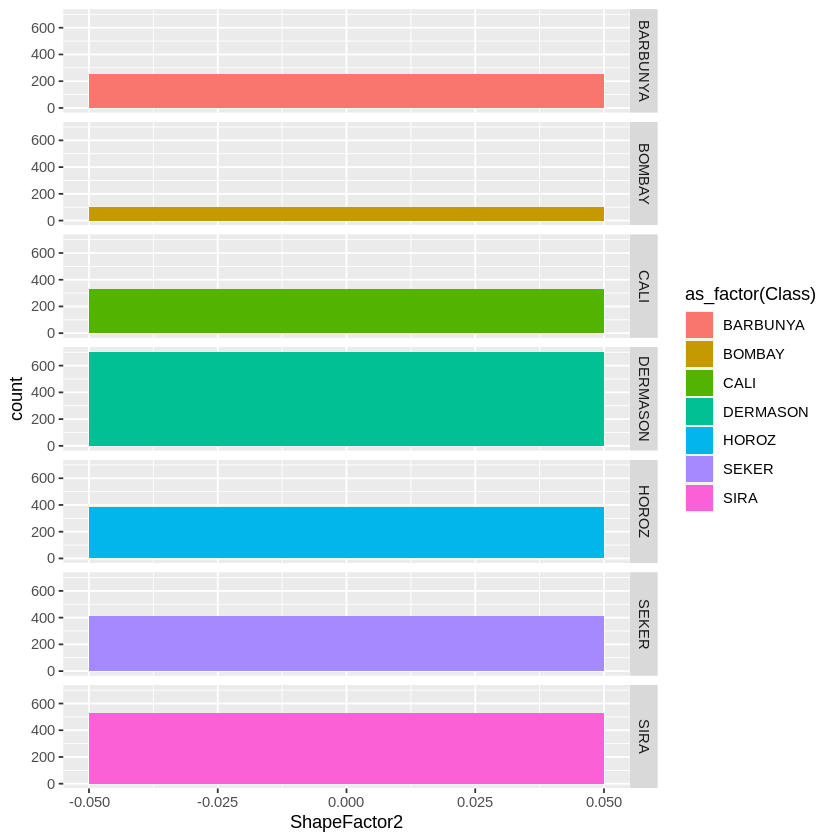

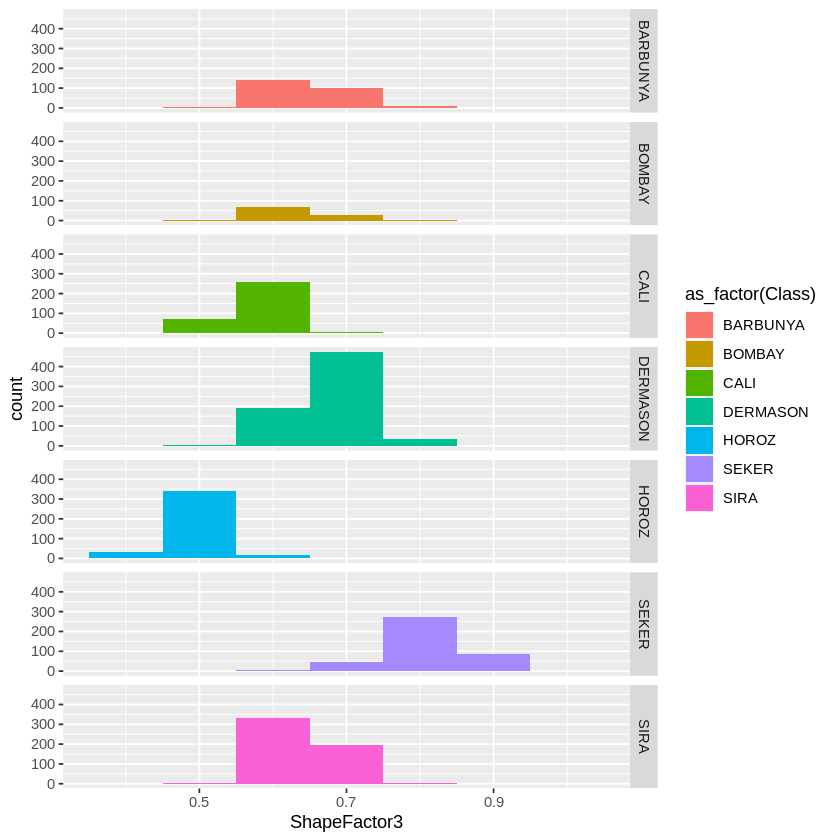

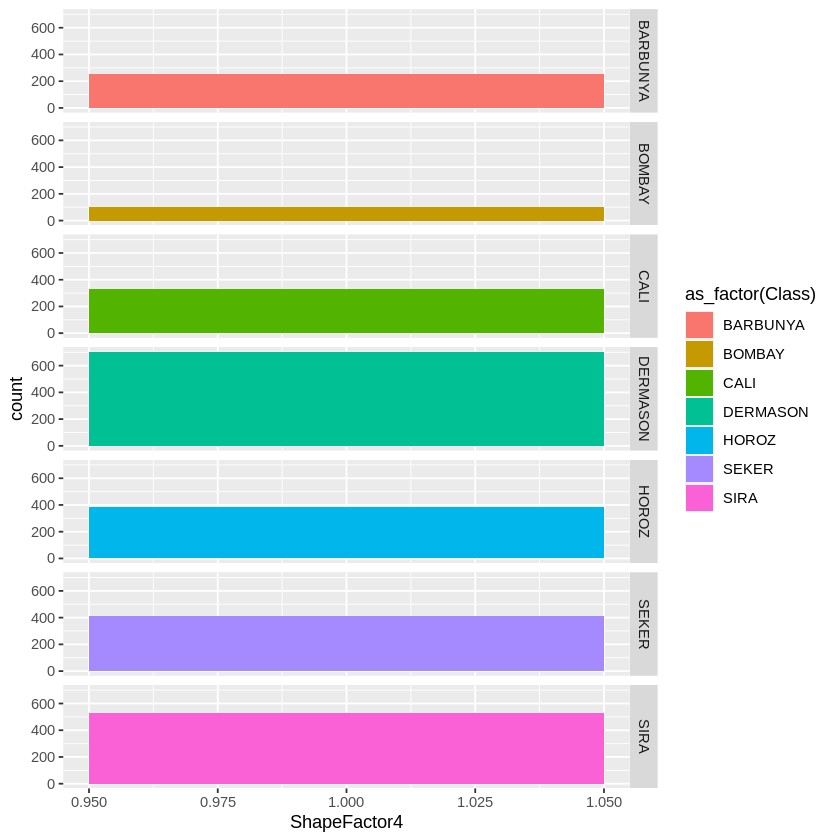

In [6]:
bean_area
bean_Perimeter
bean_MajorAxisLength
bean_MinorrAxisLength
bean_AspectRation
bean_Eccentricity
bean_ConvexArea
bean_EquivDiameter
bean_Extent
bean_Solidity
bean_roundness
bean_Compactness
bean_ShapeFactor1
bean_ShapeFactor2
bean_ShapeFactor3
bean_ShapeFactor4

 By observing the above histograms, we choose Area,Perimeter,AspectRation,Eccentricity,EquivDiameter,roundness,Compactness,ShapeFactor3 as variables as they have distinct values for classes .

Choosing the required variables by using select function

In [7]:
bean_new_train <- bean_train|>
select(Perimeter,AspectRation,Eccentricity,EquivDiameter,roundness,Compactness, Class)
bean_new_train

Perimeter,AspectRation,Eccentricity,EquivDiameter,roundness,Compactness,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
809.088,1.388543,0.6937880,247.1666,0.9210594,0.8474651,BARBUNYA
861.277,1.421234,0.7105824,251.7500,0.8432433,0.8370543,BARBUNYA
936.905,1.495246,0.7434546,266.2114,0.7968232,0.8168165,BARBUNYA
⋮,⋮,⋮,⋮,⋮,⋮,⋮
919.405,1.726859,0.8152665,269.9610,0.8509189,0.7582220,SIRA
920.668,1.763341,0.8236453,271.2573,0.8567546,0.7514878,SIRA
921.449,1.681585,0.8039647,271.6185,0.8575821,0.7676727,SIRA


The data set has 7 classes and 8 variables to work on

Splitting of data set into trianing and testing

looking the percentage of each data set

# Forward selection

In [11]:

# # select all columns (possible predictors) except Class
# names <- colnames(bean_new_train |> select (-Class))

# # Make model formula for all predictors
# model_formula <- paste("Class", "~", paste(names, collapse="+"))
# model_formula 

# # create an empty tibble to store the results
# accuracies <- tibble(size = integer(), 
#                      model_string = character(), 
#                      accuracy = numeric())

# # create a model specification
# knn_spec <- nearest_neighbor(weight_func = "rectangular", 
#                              neighbors = tune()) |>
#      set_engine("kknn") |>
#      set_mode("classification")

# # create a 5-fold cross-validation object
# BeanData_vfold <- vfold_cv(bean_train, v = 5, strata = Class)

# # store the total number of predictors
# n_total <- length(names)

# # stores selected predictors
# selected <- c()

[1] "Class ~ Perimeter+AspectRation+Eccentricity+EquivDiameter+roundness+Compactness"

In [ ]:
# # for every size from 1 to the total number of predictors
# for (i in 1:n_total) {
#     # for every predictor still not added yet
#     accs <- list()
#     models <- list()
#     for (j in 1:length(names)) {
#         # create a model string for this combination of predictors
#         preds_new <- c(selected, names[[j]])
#         model_string <- paste("Class", "~", paste(preds_new, collapse="+"))

#         # create a recipe from the model string
#         BeanData_recipe <- recipe(as.formula(model_string), 
#                                 data = bean_train) |>
#                           step_scale(all_predictors()) |>
#                           step_center(all_predictors())

#         # tune the KNN classifier with these predictors, 
#         # and collect the accuracy for the best K
#         acc <- workflow() |>
#           add_recipe( BeanData_recipe ) |>
#           add_model(knn_spec) |>
#           tune_grid(resamples = BeanData_vfold, grid = 10) |>
#           collect_metrics() |>
#           filter(.metric == "accuracy") |>
#           summarize(mx = max(mean))
#         acc <- acc$mx |> unlist()

#         # add this result to the dataframe
#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     accuracies <- accuracies |> 
#       add_row(size = i, 
#               model_string = models[[jstar]], 
#               accuracy = accs[[jstar]])
#     selected <- c(selected, names[[jstar]])
#     names <- names[-jstar]
# }
# accuracies

In [12]:
#THIS CODE IS FOR FINDING THE OPTIMAL VALUE OF K FOR OUR SELECTED MODEL

set.seed(2020) # DO NOT REMOVE
# standarization recipe

bean_recipe <- recipe(Class ~., data = bean_new_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
      set_mode("classification")

# cross validation

bean_vfold <- vfold_cv(bean_train, v = 5, strata = Class)

# Assemble into workflow
knn_results <- workflow() |>
       add_recipe(bean_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = bean_vfold, grid = 10) |>
       collect_metrics()

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8893797,5,0.005129744,Preprocessor1_Model1
1,roc_auc,hand_till,0.9431182,5,0.003510731,Preprocessor1_Model1
4,accuracy,multiclass,0.9117970,5,0.003439763,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,hand_till,0.9871306,5,0.001196470,Preprocessor1_Model8
14,accuracy,multiclass,0.9162142,5,0.005220970,Preprocessor1_Model9
14,roc_auc,hand_till,0.9873241,5,0.001301605,Preprocessor1_Model9


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8893797,5,0.005129744,Preprocessor1_Model1
4,accuracy,multiclass,0.9117970,5,0.003439763,Preprocessor1_Model2
6,accuracy,multiclass,0.9154795,5,0.005762400,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,multiclass,0.9158486,5,0.004550696,Preprocessor1_Model7
13,accuracy,multiclass,0.9165818,5,0.005348200,Preprocessor1_Model8
14,accuracy,multiclass,0.9162142,5,0.005220970,Preprocessor1_Model9


neighbors,mean
<int>,<dbl>
13,0.9165818
7,0.9165757
14,0.9162142
⋮,⋮
9,0.9143712
4,0.9117970
1,0.8893797


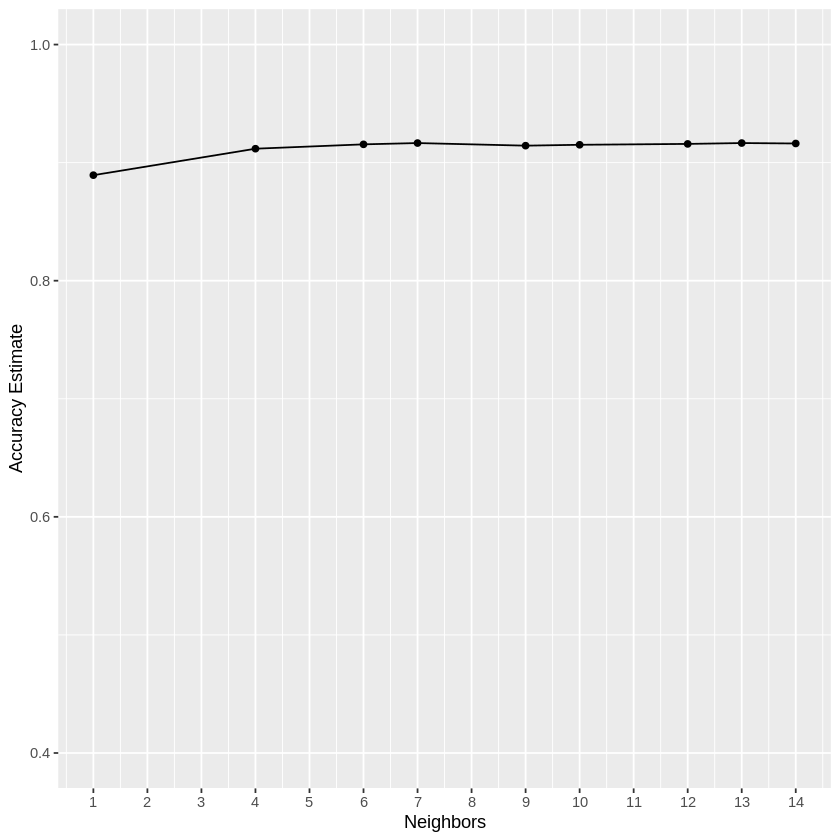

In [14]:
# THIS CODE IS FOR FINDING THE OPTIMAL VALUE OF K FOR OUR SELECTED MODEL
# find best value of number of K
accuracies <- knn_results |> 
       filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracies
accuracy_versus_k

# the highest accuracy is 91.3 and it is found at K=13
highest_accuracy <- accuracies|> select(neighbors, mean)|> arrange(desc(mean))
highest_accuracy

In [ ]:
# I DOD NOT KNOW WHAT THIS CODE IS?? WHO ADDED IT PLEASE EXPLAIN
#Preliminary exploratory data analysis:
#Create visualization to answer: can (predictor #1) and (predictor #2) be used to distinguish the dry bean types?
#goal of this visualization will be to look for patterns; since class is coloured, we can notice clusters

#Idea 1 is referencing q1.2 from classification worksheet:
options(repr.plot.width =5, repr.plot.height =3)
visualization <- ggplot(dry_bean_data, aes(x = (...), y = (...)) +
geom_point(aes(color = Class, shape = Class)) +
labs(x= "...", y= "...", color = "Type of Dry Bean") +
theme(element_text(size= 15))
# Idea 2: An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.
            
# visualization <- dry_bean_data |>
#                 ggplot(aes(x= allpredictors, fill = allpredictors)) +
#                 geom_histogram(position = "identity")
#                         visualization
#          can use facet_grid here if needed and perform functions like mutate on columns where appropriate
# before making plot


###### 